In [1]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import handshape_datasets as hd
from IPython import display
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, LeakyReLU, Dropout, Flatten
from tensorflow.keras import Model

In [3]:
#Check GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
print(tf.config.experimental.list_logical_devices('GPU'))
tf.test.is_gpu_available()

1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
import pickle

def load_dataset_with_subject(subject_test=1):
    
    data = hd.load('PugeaultASL_A')

    good_min = 40
    good_classes = []
    n_unique = len(np.unique(data[1]['y']))
    for i in range(n_unique):
        images = data[0][np.equal(i, data[1]['y'])]
        if len(images) >= good_min:
            good_classes = good_classes + [i]

    #x = data[0][np.in1d(data[1]['y'], good_classes)]

    #y = data[1]['y'][np.in1d(data[1]['y'], good_classes)]

    #s = data[1]['subjects'][np.in1d(data[1]['y'], good_classes)]

    #y_dict = dict(zip(np.unique(y), range(len(np.unique(y)))))
    #y = np.vectorize(y_dict.get)(y)

    #s_dict = dict(zip(np.unique(s), range(len(np.unique(s)))))
    #s = np.vectorize(s_dict.get)(s)
    
    x = data[0]

    y = data[1]['y']

    s = data[1]['subjects']
    
    

    classes = np.unique(y)
    n_classes = len(classes)

    x_train = x[np.not_equal(subject_test, s)]
    y_train = y[np.not_equal(subject_test, s)]
    x_test = x[np.equal(subject_test, s)]
    y_test = y[np.equal(subject_test, s)]
    
    shuffler = np.random.permutation(x_train.shape[0])
    x_train = x_train[shuffler]
    y_train = y_train[shuffler]

    shuffler_test = np.random.permutation(x_test.shape[0])
    x_test = x_test[shuffler_test]
    y_test = y_test[shuffler_test]
    
    #escalo al rango  [1-,1]
    x_train = (x_train.astype('float32') -127.5 ) / 127.5
    x_test = (x_test.astype('float32') -127.5 ) / 127.5


    return n_classes, x_train, y_train, x_test, y_test 

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    

In [5]:
def model():
    from tensorflow.keras.models import Sequential,Model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
    from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
    from tensorflow.keras.applications import DenseNet121

    base_model = DenseNet121(input_shape=(32, 32, 3), weights='imagenet', include_top=False) 

    for layer in base_model.layers:
        layer.trainable = False # capas “congeladas” no se entrenan

    output = GlobalAveragePooling2D()(base_model.output)    
    # Utilizar salida del modelo como entrada a capa Dense de 128 
    output = Dense(128, activation='relu')(output)
    # Nueva capa de salida
    output = Dense(24, activation='softmax')(output)

    # Crear nuevo modelo en base a lo anterior
    model = Model(inputs=base_model.input, outputs=output)

    return model

In [5]:
def model():
    model = tf.keras.Sequential()
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[32, 32, 3]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(24, activation='softmax'))

    return model

INFO:Loading PugeaultASL_A...


######################
#     subject 4     #
######################
### normal_model ###
Epoch 1/15
414/414 [==============================] - 4s 9ms/step - loss: 0.8033 - accuracy: 0.7617 - val_loss: 1.3554 - val_accuracy: 0.6427
Epoch 2/15
414/414 [==============================] - 3s 8ms/step - loss: 0.2964 - accuracy: 0.9090 - val_loss: 1.2582 - val_accuracy: 0.6591
Epoch 3/15
414/414 [==============================] - 3s 8ms/step - loss: 0.1983 - accuracy: 0.9374 - val_loss: 1.7452 - val_accuracy: 0.6175
Epoch 4/15
414/414 [==============================] - 3s 8ms/step - loss: 0.1613 - accuracy: 0.9485 - val_loss: 1.4237 - val_accuracy: 0.6864
Epoch 5/15
414/414 [==============================] - 3s 8ms/step - loss: 0.1285 - accuracy: 0.9590 - val_loss: 1.8117 - val_accuracy: 0.6305
Epoch 6/15
414/414 [==============================] - 3s 8ms/step - loss: 0.1159 - accuracy: 0.9627 - val_loss: 1.5375 - val_accuracy: 0.6634
Epoch 7/15
414/414 [==============================] - 3s 8m

Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/15
414/414 [==============================] - 15s 37ms/step - loss: 1.1185 - accuracy: 0.6607 - val_loss: 1.3370 - val_accuracy: 0.6161
Epoch 2/15
414/414 [==============================] - 15s 36ms/step - loss: 0.5539 - accuracy: 0.8266 - val_loss: 1.3246 - val_accuracy: 0.6304
Epoch 3/15
414/414 [==============================] - 15s 36ms/step - loss: 0.4098 - accuracy: 0.8717 - val_loss: 1.1794 - val_accuracy: 0.6821
Epoch 4/15
414/414 [==============================] - 15s 37ms/step - loss: 0.3397 - accuracy: 0.8900 - val_loss: 1.5495 - val_accuracy: 0.6459
Epoch 5/15
414/414 [==============================] - 15s 36ms/step - loss: 0.2947 - accuracy: 0.9052 - val_loss: 1.3858 - val_accuracy: 0.6727
Epoch 6/15
414/414 [==============================] - 15s 36ms/step - loss: 0.2655 - accuracy: 0.9143 - val_loss: 1.2846 - val_accuracy: 0.7053
Epoch 7/15
414/414 [==============================] - 15s 36ms/step - loss: 0.2441 - accuracy: 0.9220 - val_loss: 1.1734 - val_accuracy:

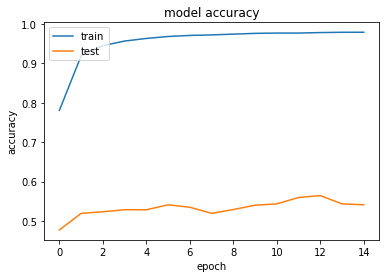

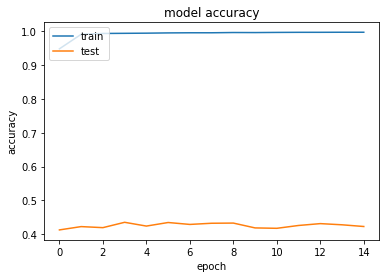

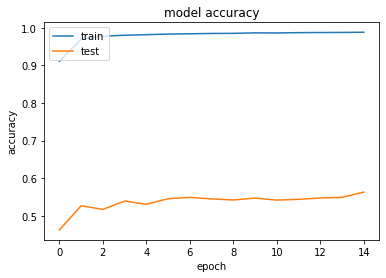

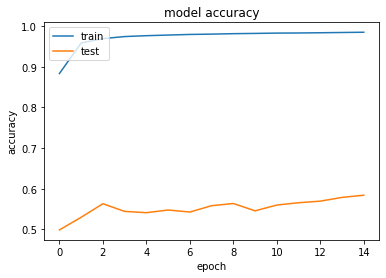

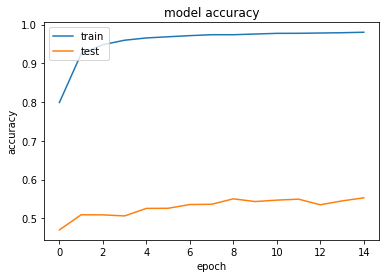

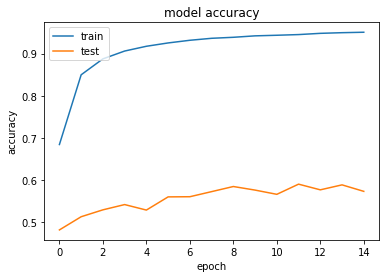

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
avg_normal_history= {}
avg_x_agu_100_history= {}
avg_x_agu_75_history= {}
avg_x_agu_50_history= {}
avg_x_agu_25_history= {}
avg_train_gen_history= {}

for i in range(4,5):
    
    print('######################')
    print('#     subject {}     #'.format(i))
    print('######################')
    ##################
    # cargo datasets #
    ##################
    
    numpy_data_path = 'numpy_data/subject_{}/'.format(i)
    #data original
    n_classes, x_train, y_train, x_test, y_test = load_dataset_with_subject(subject_test=i)
    # Data 100% GAN
    x_agu_100 = np.load(numpy_data_path+'x_aug_100.npy')
    y_agu_100 = np.load(numpy_data_path+'y_aug_100.npy')
    # Data 75/25 (GAN/normal)
    x_agu_75 = np.load(numpy_data_path+'x_aug_75.npy')
    y_agu_75 = np.load(numpy_data_path+'y_aug_75.npy')
    # Data 50/50 (GAN/normal)
    x_agu_50 = np.load(numpy_data_path+'x_aug_50.npy')
    y_agu_50 = np.load(numpy_data_path+'y_aug_50.npy')
    # Data 25/75 (GAN/normal)
    x_agu_25 = np.load(numpy_data_path+'x_aug_25.npy')
    y_agu_25 = np.load(numpy_data_path+'y_aug_25.npy')
    
    #Generator con data augmentation
    train_datagen_aug = ImageDataGenerator(rotation_range=20)

    train_datagen_aug.fit(x_train)
    train_gen =  train_datagen_aug.flow(x_train, y_train, batch_size=128)
    
    
    #####################
    # Defino los modelos#
    #####################
    normal_model = model()
    x_agu_100_model = model()
    x_agu_75_model = model()
    x_agu_50_model = model()
    x_agu_25_model = model()
    train_gen_model = model()
    
    #Compilo
    normal_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    x_agu_100_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    x_agu_75_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    x_agu_50_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    x_agu_25_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    train_gen_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    #train normal model
    print('### normal_model ###')
    normal_history= normal_model.fit(x_train, y_train, batch_size=128, epochs=15, 
                                          validation_data=(x_test, y_test))
    #train x_agu_100 model
    print('### x_agu_100 ###')
    x_agu_100_history= x_agu_100_model.fit(x_agu_100, y_agu_100, batch_size=128, epochs=15, 
                                          validation_data=(x_test, y_test))
    #train x_agu_75 model
    print('### x_agu_75 ###')
    x_agu_75_history= x_agu_75_model.fit(x_agu_75, y_agu_75, batch_size=128, epochs=15, 
                                          validation_data=(x_test, y_test))
    #train x_agu_50 model
    print('### x_agu_50 ###')
    x_agu_50_history= x_agu_50_model.fit(x_agu_50, y_agu_50, batch_size=128, epochs=15, 
                                          validation_data=(x_test, y_test))
    #train x_agu_25 model
    print('### x_agu_25 ###')
    x_agu_25_history= x_agu_25_model.fit(x_agu_25, y_agu_25, batch_size=128, epochs=15, 
                                          validation_data=(x_test, y_test))
    #train train_gen model
    print('### train_gen ###')
    train_gen_history = train_gen_model.fit_generator(train_gen, 
                               steps_per_epoch=len(x_train) / 128,epochs=15, 
                               validation_data=(x_test, y_test))
    
    if i==0:
        '''avg_normal_history= normal_history.history
        avg_x_agu_100_history= x_agu_100_history.history
        avg_x_agu_75_history= x_agu_75_history.history
        avg_x_agu_50_history= x_agu_50_history.history
        avg_x_agu_25_history= x_agu_25_history.history
        avg_train_gen_history = train_gen_history.history'''
        #avg_normal_history
        save_obj(normal_history.history, 'avg_normal_history')
        #avg_x_agu_100_history
        save_obj(x_agu_100_history.history, 'avg_x_agu_100_history')
        #avg_x_agu_75_history
        save_obj(x_agu_75_history.history, 'avg_x_agu_75_history')
        #avg_x_agu_50_history
        save_obj(x_agu_50_history.history, 'avg_x_agu_50_history')
        #avg_x_agu_25_history
        save_obj(x_agu_25_history.history, 'avg_x_agu_25_history')
        #avg_train_gen_history
        save_obj(train_gen_history.history, 'avg_train_gen_history')
    else:
        #avg_normal_history
        avg_normal_history = load_obj('avg_normal_history')
        avg_normal_history['loss'] = [x + y for x, y in zip(avg_normal_history['loss'],normal_history.history['loss'])]
        avg_normal_history['accuracy'] = [x + y for x, y in zip(avg_normal_history['accuracy'],normal_history.history['accuracy'])]
        avg_normal_history['val_loss'] = [x + y for x, y in zip(avg_normal_history['val_loss'],normal_history.history['val_loss'])]
        avg_normal_history['val_accuracy'] = [x + y for x, y in zip(avg_normal_history['val_accuracy'],normal_history.history['val_accuracy'])]
        #save_obj(avg_normal_history, 'avg_normal_history')
        #avg_x_agu_100_history
        avg_x_agu_100_history = load_obj('avg_x_agu_100_history')
        avg_x_agu_100_history['loss'] = [x + y for x, y in zip(avg_x_agu_100_history['loss'],x_agu_100_history.history['loss'])]
        avg_x_agu_100_history['accuracy'] = [x + y for x, y in zip(avg_x_agu_100_history['accuracy'],x_agu_100_history.history['accuracy'])]
        avg_x_agu_100_history['val_loss'] = [x + y for x, y in zip(avg_x_agu_100_history['val_loss'],x_agu_100_history.history['val_loss'])]
        avg_x_agu_100_history['val_accuracy'] = [x + y for x, y in zip(avg_x_agu_100_history['val_accuracy'],x_agu_100_history.history['val_accuracy'])]
        #save_obj(avg_x_agu_100_history, 'avg_x_agu_100_history')
        #avg_x_agu_75_history
        avg_x_agu_75_history = load_obj('avg_x_agu_75_history')
        avg_x_agu_75_history['loss'] = [x + y for x, y in zip(avg_x_agu_75_history['loss'],x_agu_75_history.history['loss'])]
        avg_x_agu_75_history['accuracy'] = [x + y for x, y in zip(avg_x_agu_75_history['accuracy'],x_agu_75_history.history['accuracy'])]
        avg_x_agu_75_history['val_loss'] = [x + y for x, y in zip(avg_x_agu_75_history['val_loss'],x_agu_75_history.history['val_loss'])]
        avg_x_agu_75_history['val_accuracy'] = [x + y for x, y in zip(avg_x_agu_75_history['val_accuracy'],x_agu_75_history.history['val_accuracy'])]
        #save_obj(avg_x_agu_75_history, 'avg_x_agu_75_history')
        #avg_x_agu_50_history
        avg_x_agu_50_history = load_obj('avg_x_agu_50_history')
        avg_x_agu_50_history['loss'] = [x + y for x, y in zip(avg_x_agu_50_history['loss'],x_agu_50_history.history['loss'])]
        avg_x_agu_50_history['accuracy'] = [x + y for x, y in zip(avg_x_agu_50_history['accuracy'],x_agu_50_history.history['accuracy'])]
        avg_x_agu_50_history['val_loss'] = [x + y for x, y in zip(avg_x_agu_50_history['val_loss'],x_agu_50_history.history['val_loss'])]
        avg_x_agu_50_history['val_accuracy'] = [x + y for x, y in zip(avg_x_agu_50_history['val_accuracy'],x_agu_50_history.history['val_accuracy'])]
        #save_obj(avg_x_agu_50_history, 'avg_x_agu_50_history')
        #avg_x_agu_25_history
        avg_x_agu_25_history = load_obj('avg_x_agu_25_history')
        avg_x_agu_25_history['loss'] = [x + y for x, y in zip(avg_x_agu_25_history['loss'],x_agu_25_history.history['loss'])]
        avg_x_agu_25_history['accuracy'] = [x + y for x, y in zip(avg_x_agu_25_history['accuracy'],x_agu_25_history.history['accuracy'])]
        avg_x_agu_25_history['val_loss'] = [x + y for x, y in zip(avg_x_agu_25_history['val_loss'],x_agu_25_history.history['val_loss'])]
        avg_x_agu_25_history['val_accuracy'] = [x + y for x, y in zip(avg_x_agu_25_history['val_accuracy'],x_agu_25_history.history['val_accuracy'])]
        #save_obj(avg_x_agu_25_history, 'avg_x_agu_25_history')
        #avg_train_gen_history
        avg_train_gen_history = load_obj('avg_train_gen_history')
        avg_train_gen_history['loss'] = [x + y for x, y in zip(avg_train_gen_history['loss'],train_gen_history.history['loss'])]
        avg_train_gen_history['accuracy'] = [x + y for x, y in zip(avg_train_gen_history['accuracy'],train_gen_history.history['accuracy'])]
        avg_train_gen_history['val_loss'] = [x + y for x, y in zip(avg_train_gen_history['val_loss'],train_gen_history.history['val_loss'])]
        avg_train_gen_history['val_accuracy'] = [x + y for x, y in zip(avg_train_gen_history['val_accuracy'],train_gen_history.history['val_accuracy'])]
        #save_obj(avg_train_gen_history, 'avg_train_gen_history')
        
        #liberamos memoria
        del normal_model, x_agu_100_model, x_agu_75_model, x_agu_50_model, x_agu_25_model
        del train_gen_model, x_train, y_train, x_test, y_test, x_agu_100, y_agu_100
        del x_agu_75, y_agu_75, x_agu_50, y_agu_50, x_agu_25, y_agu_25, train_gen
        #Check GPU
        
        gpus = tf.config.experimental.list_physical_devices('GPU')
        if gpus:
            try:
                # Currently, memory growth needs to be the same across GPUs
                for gpu in gpus:
                      tf.config.experimental.set_memory_growth(gpu, True)
                logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
            except RuntimeError as e:
                # Memory growth must be set before GPUs have been initialized
                print(e)

        print(tf.config.experimental.list_logical_devices('GPU'))
        tf.test.is_gpu_available()

#avg_normal_history
avg_normal_history['loss'] = [element / 5 for element in avg_normal_history['loss']]
avg_normal_history['accuracy'] =  [element / 5 for element in avg_normal_history['accuracy']]
avg_normal_history['val_loss'] =  [element / 5 for element in avg_normal_history['val_loss']]
avg_normal_history['val_accuracy'] =  [element / 5 for element in avg_normal_history['val_accuracy']]
save_obj(avg_normal_history, 'avg_normal_history')
#avg_x_agu_100_history
avg_x_agu_100_history['loss'] =[element / 5 for element in avg_x_agu_100_history['loss']]
avg_x_agu_100_history['accuracy'] = [element / 5 for element in avg_x_agu_100_history['accuracy']]
avg_x_agu_100_history['val_loss'] = [element / 5 for element in avg_x_agu_100_history['val_loss']]
avg_x_agu_100_history['val_accuracy'] = [element / 5 for element in avg_x_agu_100_history['val_accuracy']]
save_obj(avg_x_agu_100_history, 'avg_x_agu_100_history')
#avg_x_agu_75_history
avg_x_agu_75_history['loss'] = [element / 5 for element in avg_x_agu_75_history['loss']]
avg_x_agu_75_history['accuracy'] = [element / 5 for element in avg_x_agu_75_history['accuracy']]
avg_x_agu_75_history['val_loss'] = [element / 5 for element in avg_x_agu_75_history['val_loss']]
avg_x_agu_75_history['val_accuracy'] = [element / 5 for element in avg_x_agu_75_history['val_accuracy']]
save_obj(avg_x_agu_75_history, 'avg_x_agu_75_history')
#avg_x_agu_50_history
avg_x_agu_50_history['loss'] = [element / 5 for element in avg_x_agu_50_history['loss']]
avg_x_agu_50_history['accuracy'] =  [element / 5 for element in avg_x_agu_50_history['accuracy']]
avg_x_agu_50_history['val_loss'] =  [element / 5 for element in avg_x_agu_50_history['val_loss']]
avg_x_agu_50_history['val_accuracy'] =  [element / 5 for element in avg_x_agu_50_history['val_accuracy']]
save_obj(avg_x_agu_50_history, 'avg_x_agu_50_history')
#avg_x_agu_25_history
avg_x_agu_25_history['loss'] = [element / 5 for element in avg_x_agu_25_history['loss']]
avg_x_agu_25_history['accuracy'] =  [element / 5 for element in avg_x_agu_25_history['accuracy']]
avg_x_agu_25_history['val_loss'] =  [element / 5 for element in avg_x_agu_25_history['val_loss']]
avg_x_agu_25_history['val_accuracy'] =  [element / 5 for element in avg_x_agu_25_history['val_accuracy']]
save_obj(avg_x_agu_25_history, 'avg_x_agu_25_history')
#avg_train_gen_history
avg_train_gen_history['loss'] = [element / 5 for element in avg_train_gen_history['loss']]
avg_train_gen_history['accuracy'] =  [element / 5 for element in avg_train_gen_history['accuracy']]
avg_train_gen_history['val_loss'] =  [element / 5 for element in avg_train_gen_history['val_loss']]
avg_train_gen_history['val_accuracy'] =  [element / 5 for element in avg_train_gen_history['val_accuracy']]                                       
save_obj(avg_train_gen_history, 'avg_train_gen_history')  

historys_path = 'historys/PugeaultASL_A/'
                                          
#avg_normal_history
# summarize _history for accuracy
plt.plot(avg_normal_history['accuracy'])
plt.plot(avg_normal_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(historys_path+'avg_normal_history')
plt.show()

#avg_x_agu_100_history
# summarize _history for accuracy
plt.plot(avg_x_agu_100_history['accuracy'])
plt.plot(avg_x_agu_100_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(historys_path+'avg_x_agu_100_history')
plt.show()

#avg_x_agu_75_history
# summarize _history for accuracy
plt.plot(avg_x_agu_75_history['accuracy'])
plt.plot(avg_x_agu_75_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(historys_path+'avg_x_agu_75_history')                                          
plt.show()
                                          
#avg_x_agu_50_history
# summarize _history for accuracy
plt.plot(avg_x_agu_50_history['accuracy'])
plt.plot(avg_x_agu_50_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(historys_path+'avg_x_agu_50_history')                                            
plt.show()
                                          
#avg_x_agu_25_history
# summarize _history for accuracy
plt.plot(avg_x_agu_25_history['accuracy'])
plt.plot(avg_x_agu_25_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(historys_path+'avg_x_agu_25_history')                                             
plt.show()
                                        
#avg_train_gen_history
# summarize _history for accuracy
plt.plot(avg_train_gen_history['accuracy'])
plt.plot(avg_train_gen_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(historys_path+'avg_train_gen_history')    
plt.show()

In [6]:
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt
import seaborn as sns

avg_normal_history = []
avg_x_agu_50_history = []
for i in range(0,5):
    
    print('######################')
    print('#     subject {}     #'.format(i))
    print('######################')
    ##################
    # cargo datasets #
    ##################
    
    numpy_data_path = 'numpy_data/subject_{}/'.format(i)
    #data original
    n_classes, x_train, y_train, x_test, y_test = load_dataset_with_subject(subject_test=i)
    # Data 50/50 (GAN/normal)
    x_agu_50 = np.load(numpy_data_path+'x_aug_50.npy')
    y_agu_50 = np.load(numpy_data_path+'y_aug_50.npy')
     
    #####################
    # Defino los modelos#
    #####################
    normal_model = model()
    x_agu_50_model = model()
    
    #Compilo
    normal_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    x_agu_50_model.compile(optimizer='Adam', 
                             loss='sparse_categorical_crossentropy', 
                             metrics=['accuracy'])
    
    
    #train normal model
    print('### normal_model ###')
    normal_history= normal_model.fit(x_train, y_train, batch_size=128, epochs=50, 
                                          validation_data=(x_test, y_test))
    #train x_agu_50 model
    print('### x_agu_50 ###')
    x_agu_50_history= x_agu_50_model.fit(x_agu_50, y_agu_50, batch_size=128, epochs=50, 
                                          validation_data=(x_test, y_test))
    
    
    avg_normal_history.append(normal_history.history['val_accuracy'])
    avg_x_agu_50_history.append(x_agu_50_history.history['val_accuracy'])
        
    #liberamos memoria
    del normal_model, x_agu_50_model, x_train, y_train, x_test, y_test, x_agu_50, y_agu_50

    #Check GPU
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                  tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

    print(tf.config.experimental.list_logical_devices('GPU'))
    tf.test.is_gpu_available()

avg_normal_history = np.asarray(avg_normal_history)
avg_x_agu_50_history = np.asarray(avg_x_agu_50_history)

historys_path = 'historys/PugeaultASL_A/'
                                          
'''#avg_normal_history
# summarize _history for accuracy
plt.plot(avg_x_agu_50_history['val_accuracy'])
plt.plot(avg_normal_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy_50/50', 'val_accuracy_100_real'], loc='upper left')
#plt.savefig(historys_path+'avg_normal_history')
plt.show()'''

def tsplot(data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    plt.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    plt.plot(est,**kw)
    plt.margins(x=0)

tsplot(avg_normal_history)
tsplot(avg_x_agu_50_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_50/50', 'val_100_real'], loc='upper left')
plt.savefig(historys_path+'50_real-50_fakevs100_real')
plt.show()


                           

INFO:Loading PugeaultASL_A...


######################
#     subject 0     #
######################
### normal_model ###
Epoch 1/50
416/416 [==============================] - 4s 9ms/step - loss: 0.7668 - accuracy: 0.7709 - val_loss: 2.4524 - val_accuracy: 0.4466
Epoch 2/50
416/416 [==============================] - 4s 9ms/step - loss: 0.2799 - accuracy: 0.9140 - val_loss: 2.6621 - val_accuracy: 0.4670
Epoch 3/50
416/416 [==============================] - 4s 8ms/step - loss: 0.1942 - accuracy: 0.9400 - val_loss: 2.6306 - val_accuracy: 0.4741
Epoch 4/50
416/416 [==============================] - 4s 8ms/step - loss: 0.1496 - accuracy: 0.9528 - val_loss: 3.4335 - val_accuracy: 0.4363
Epoch 5/50
416/416 [==============================] - 4s 9ms/step - loss: 0.1239 - accuracy: 0.9600 - val_loss: 3.6578 - val_accuracy: 0.4280
Epoch 6/50
416/416 [==============================] - 4s 9ms/step - loss: 0.1091 - accuracy: 0.9641 - val_loss: 3.5602 - val_accuracy: 0.4633
Epoch 7/50
416/416 [==============================] - 4s 8m

920/920 [==============================] - 7s 8ms/step - loss: 0.0744 - accuracy: 0.9784 - val_loss: 4.2212 - val_accuracy: 0.4986
Epoch 8/50
920/920 [==============================] - 7s 8ms/step - loss: 0.0737 - accuracy: 0.9791 - val_loss: 4.3505 - val_accuracy: 0.5199
Epoch 9/50
920/920 [==============================] - 7s 8ms/step - loss: 0.0690 - accuracy: 0.9807 - val_loss: 5.0999 - val_accuracy: 0.4903
Epoch 10/50
920/920 [==============================] - 7s 8ms/step - loss: 0.0735 - accuracy: 0.9806 - val_loss: 4.6066 - val_accuracy: 0.5586
Epoch 11/50
920/920 [==============================] - 7s 8ms/step - loss: 0.0690 - accuracy: 0.9820 - val_loss: 4.3716 - val_accuracy: 0.5537
Epoch 12/50
920/920 [==============================] - 7s 8ms/step - loss: 0.0666 - accuracy: 0.9826 - val_loss: 6.0535 - val_accuracy: 0.5113
Epoch 13/50
920/920 [==============================] - 7s 8ms/step - loss: 0.0762 - accuracy: 0.9821 - val_loss: 4.5370 - val_accuracy: 0.5837
Epoch 14/50
9

INFO:Loading PugeaultASL_A...


1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
######################
#     subject 1     #
######################
### normal_model ###
Epoch 1/50
406/406 [==============================] - 4s 9ms/step - loss: 0.7325 - accuracy: 0.7798 - val_loss: 1.9498 - val_accuracy: 0.5391
Epoch 2/50
406/406 [==============================] - 4s 9ms/step - loss: 0.2533 - accuracy: 0.9210 - val_loss: 2.1705 - val_accuracy: 0.5559
Epoch 3/50
406/406 [==============================] - 4s 9ms/step - loss: 0.1622 - accuracy: 0.9491 - val_loss: 2.4411 - val_accuracy: 0.5396
Epoch 4/50
406/406 [==============================] - 4s 9ms/step - loss: 0.1277 - accuracy: 0.9588 - val_loss: 2.9431 - val_accuracy: 0.5473
Epoch 5/50
406/406 [==============================] - 4s 9ms/step - loss: 0.1092 - accuracy: 0.9644 - val_loss: 2.7416 - val_accuracy: 0.5799
Epoch 6/50
406/406 [==============================] - 4s 9ms/step - loss: 0.0977 - accuracy: 0.9678 - val_loss: 

910/910 [==============================] - 7s 8ms/step - loss: 0.0648 - accuracy: 0.9805 - val_loss: 3.5450 - val_accuracy: 0.5571
Epoch 8/50
910/910 [==============================] - 7s 8ms/step - loss: 0.0606 - accuracy: 0.9823 - val_loss: 4.0222 - val_accuracy: 0.5932
Epoch 9/50
910/910 [==============================] - 7s 8ms/step - loss: 0.0638 - accuracy: 0.9820 - val_loss: 3.9634 - val_accuracy: 0.6013
Epoch 10/50
910/910 [==============================] - 7s 8ms/step - loss: 0.0618 - accuracy: 0.9830 - val_loss: 4.0540 - val_accuracy: 0.6133
Epoch 11/50
910/910 [==============================] - 7s 8ms/step - loss: 0.0624 - accuracy: 0.9842 - val_loss: 4.5961 - val_accuracy: 0.5997
Epoch 12/50
910/910 [==============================] - 7s 8ms/step - loss: 0.0603 - accuracy: 0.9845 - val_loss: 4.7215 - val_accuracy: 0.6189
Epoch 13/50
910/910 [==============================] - 7s 8ms/step - loss: 0.0649 - accuracy: 0.9846 - val_loss: 5.0049 - val_accuracy: 0.6246
Epoch 14/50
9

INFO:Loading PugeaultASL_A...


######################
#     subject 2     #
######################
### normal_model ###
Epoch 1/50
410/410 [==============================] - 4s 9ms/step - loss: 0.7363 - accuracy: 0.7798 - val_loss: 2.2450 - val_accuracy: 0.5110
Epoch 2/50
410/410 [==============================] - 4s 9ms/step - loss: 0.2644 - accuracy: 0.9184 - val_loss: 2.1231 - val_accuracy: 0.5790
Epoch 3/50
410/410 [==============================] - 4s 9ms/step - loss: 0.1799 - accuracy: 0.9418 - val_loss: 2.4253 - val_accuracy: 0.5787
Epoch 4/50
410/410 [==============================] - 4s 9ms/step - loss: 0.1365 - accuracy: 0.9571 - val_loss: 2.7013 - val_accuracy: 0.5886
Epoch 5/50
410/410 [==============================] - 4s 9ms/step - loss: 0.1194 - accuracy: 0.9603 - val_loss: 2.6574 - val_accuracy: 0.5764
Epoch 6/50
410/410 [==============================] - 4s 9ms/step - loss: 0.0943 - accuracy: 0.9694 - val_loss: 2.9855 - val_accuracy: 0.5709
Epoch 7/50
410/410 [==============================] - 4s 9m

914/914 [==============================] - 7s 8ms/step - loss: 0.0661 - accuracy: 0.9803 - val_loss: 3.7506 - val_accuracy: 0.5730
Epoch 8/50
914/914 [==============================] - 7s 8ms/step - loss: 0.0655 - accuracy: 0.9807 - val_loss: 3.8701 - val_accuracy: 0.6158
Epoch 9/50
914/914 [==============================] - 7s 8ms/step - loss: 0.0616 - accuracy: 0.9826 - val_loss: 3.4222 - val_accuracy: 0.6081
Epoch 10/50
914/914 [==============================] - 7s 8ms/step - loss: 0.0660 - accuracy: 0.9823 - val_loss: 3.7791 - val_accuracy: 0.6229
Epoch 11/50
914/914 [==============================] - 7s 8ms/step - loss: 0.0627 - accuracy: 0.9835 - val_loss: 4.3386 - val_accuracy: 0.6238
Epoch 12/50
914/914 [==============================] - 7s 8ms/step - loss: 0.0638 - accuracy: 0.9844 - val_loss: 4.3719 - val_accuracy: 0.6182
Epoch 13/50
914/914 [==============================] - 7s 8ms/step - loss: 0.0633 - accuracy: 0.9845 - val_loss: 4.9339 - val_accuracy: 0.6168
Epoch 14/50
9

INFO:Loading PugeaultASL_A...


1 Physical GPUs, 1 Logical GPUs
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
######################
#     subject 3     #
######################
### normal_model ###
Epoch 1/50
412/412 [==============================] - 18s 44ms/step - loss: 0.6490 - accuracy: 0.8081 - val_loss: 3.8379 - val_accuracy: 0.3256
Epoch 2/50
412/412 [==============================] - 4s 9ms/step - loss: 0.2218 - accuracy: 0.9325 - val_loss: 4.0757 - val_accuracy: 0.3282
Epoch 3/50
412/412 [==============================] - 4s 9ms/step - loss: 0.1391 - accuracy: 0.9563 - val_loss: 4.5711 - val_accuracy: 0.3445
Epoch 4/50
412/412 [==============================] - 4s 9ms/step - loss: 0.1121 - accuracy: 0.9638 - val_loss: 5.2596 - val_accuracy: 0.3287
Epoch 5/50
412/412 [==============================] - 4s 9ms/step - loss: 0.0910 - accuracy: 0.9709 - val_loss: 5.2440 - val_accuracy: 0.3333
Epoch 6/50
412/412 [==============================] - 4s 9ms/step - loss: 0.0817 - accuracy: 0.9732 - val_loss

Epoch 7/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0558 - accuracy: 0.9838 - val_loss: 7.7071 - val_accuracy: 0.3806
Epoch 8/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0546 - accuracy: 0.9846 - val_loss: 7.7476 - val_accuracy: 0.3864
Epoch 9/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0538 - accuracy: 0.9860 - val_loss: 9.0371 - val_accuracy: 0.3642
Epoch 10/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0523 - accuracy: 0.9864 - val_loss: 7.8780 - val_accuracy: 0.4218
Epoch 11/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0553 - accuracy: 0.9866 - val_loss: 10.1291 - val_accuracy: 0.3685
Epoch 12/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0536 - accuracy: 0.9872 - val_loss: 10.0585 - val_accuracy: 0.3952
Epoch 13/50
916/916 [==============================] - 7s 8ms/step - loss: 0.0502 - accuracy: 0.9883 - val_loss: 12.8133 - val_accuracy: 0.3664

INFO:Loading PugeaultASL_A...


######################
#     subject 4     #
######################
### normal_model ###
Epoch 1/50
414/414 [==============================] - 4s 8ms/step - loss: 0.8097 - accuracy: 0.7565 - val_loss: 1.4026 - val_accuracy: 0.6119
Epoch 2/50
414/414 [==============================] - 3s 8ms/step - loss: 0.2999 - accuracy: 0.9071 - val_loss: 1.2115 - val_accuracy: 0.6882
Epoch 3/50
414/414 [==============================] - 3s 8ms/step - loss: 0.2036 - accuracy: 0.9364 - val_loss: 1.4311 - val_accuracy: 0.6703
Epoch 4/50
414/414 [==============================] - 3s 8ms/step - loss: 0.1532 - accuracy: 0.9511 - val_loss: 1.4969 - val_accuracy: 0.6468
Epoch 5/50
414/414 [==============================] - 3s 8ms/step - loss: 0.1325 - accuracy: 0.9573 - val_loss: 1.6562 - val_accuracy: 0.6598
Epoch 6/50
414/414 [==============================] - 3s 8ms/step - loss: 0.1116 - accuracy: 0.9638 - val_loss: 1.5490 - val_accuracy: 0.6781
Epoch 7/50
414/414 [==============================] - 3s 8m

918/918 [==============================] - 7s 8ms/step - loss: 0.0845 - accuracy: 0.9741 - val_loss: 2.0779 - val_accuracy: 0.6763
Epoch 8/50
918/918 [==============================] - 7s 8ms/step - loss: 0.0795 - accuracy: 0.9765 - val_loss: 1.8671 - val_accuracy: 0.7195
Epoch 9/50
918/918 [==============================] - 7s 8ms/step - loss: 0.0809 - accuracy: 0.9768 - val_loss: 2.0204 - val_accuracy: 0.6760
Epoch 10/50
918/918 [==============================] - 7s 8ms/step - loss: 0.0794 - accuracy: 0.9777 - val_loss: 2.0828 - val_accuracy: 0.6751
Epoch 11/50
918/918 [==============================] - 7s 8ms/step - loss: 0.0748 - accuracy: 0.9798 - val_loss: 2.3324 - val_accuracy: 0.6853
Epoch 12/50
918/918 [==============================] - 7s 8ms/step - loss: 0.0772 - accuracy: 0.9794 - val_loss: 2.3259 - val_accuracy: 0.6958
Epoch 13/50
918/918 [==============================] - 7s 8ms/step - loss: 0.0767 - accuracy: 0.9804 - val_loss: 2.5649 - val_accuracy: 0.6907
Epoch 14/50
9

NameError: name 'x' is not defined

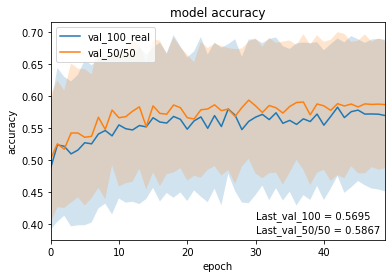

In [50]:
def tsplot(data,**kw):
    x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    plt.fill_between(x, cis[0],cis[1],alpha=0.2, **kw)
    plt.plot(est,**kw)
    plt.margins(x=0)
    
    return est

est_norm = tsplot(avg_normal_history)
est_gan = tsplot(avg_x_agu_50_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_100_real', 'val_50/50'], loc='upper left')
plt.savefig(historys_path+'50_real-50_fakevs100_real')
plt.figtext(.6, .2, "Last_val_100 = {}".format(str(est_norm[-1])[0:6]))
plt.figtext(.6, .15, "Last_val_50/50 = {}".format(str(est_gan[-1])[0:6]))
plt.savefig(historys_path+'50_real-50_fakevs100_real')
plt.show()

In [39]:
str(est_norm[-1])[0:6]

'0.5695'

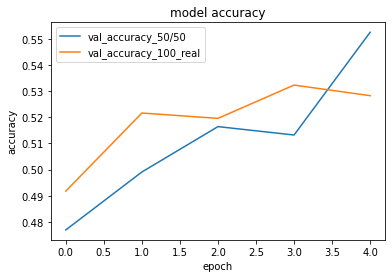

In [18]:
#avg_normal_history
# summarize _history for accuracy
plt.plot(np.mean(avg_normal_history,axis=0))
plt.plot(np.mean(avg_x_agu_50_history,axis=0))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy_50/50', 'val_accuracy_100_real'], loc='upper left')
#plt.savefig(historys_path+'50_real-50_fakevs100_real')
plt.show()

In [1]:
import seaborn as sns

gammas = sns.load_dataset("gammas")
ax = sns.tsplot(time="timepoint", value="BOLD signal",
                 unit="subject", condition="ROI",
                 data=gammas)

AttributeError: module 'seaborn' has no attribute 'tsplot'

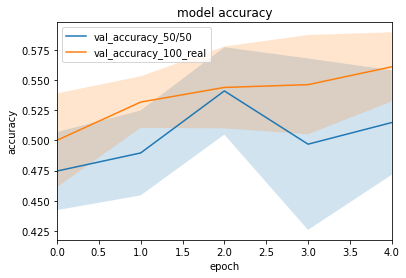

In [28]:
import numpy as np; np.random.seed(1)
import matplotlib.pyplot as plt
import seaborn as sns

def tsplot(data,**kw):
    #x = np.arange(data.shape[1])
    est = np.mean(data, axis=0)
    sd = np.std(data, axis=0)
    cis = (est - sd, est + sd)
    plt.fill_between(x,cis[0],cis[1],alpha=0.2, **kw)
    plt.plot(est,**kw)
    plt.margins(x=0)

tsplot(avg_normal_history)
tsplot(avg_x_agu_50_history)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['val_accuracy_50/50', 'val_accuracy_100_real'], loc='upper left')
plt.show()